# Sky maps

In [1]:
import gammapy
gammapy.__version__

'0.18.2'

In [1]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import setup
from setup import col_n, col_s, col_b, dtpop
from pop_plot import col_size, sig_legend, history, plot_historical, redshift, eiso
import init as init

from utilities import MyLabel, single_legend, stamp, projected_scatter

# plt.style.use('seaborn-talk') # Make the labels readable
plt.style.use('seaborn-poster') # Make the labels readable - bug with normal x marker !!!

## Read data - create the total population - infer detection level

In [2]:
# Open data, get population
file = init.create_csv(debug=True)
(grb, gn0, gs0, gn, gs, gb) = init.get_data(file, debug=False)

# filetag for Stamp
filetag = file.parent.name

# Effective det_level
eff_lvl = init.get_eff_lvl(grb)

import pandas as pd
fullpop = pd.concat([gn0,gs0,gb],axis=0)
len(fullpop)

Full name : ..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc\data.txt
 >>>  ..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc\data.csv
..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc\data.csv  exists
 Detection level =  0.9  niter =  100  -> Eff. det. level is  90.0


611

## Reference population

In [3]:
popref   = grb[grb.site=="North"] # Get initial population (restrict ot one of N, S, B)
popNS    = grb[(grb.site=="North") | (grb.site=="South")]
len(popNS)

2000

In [11]:
import astropy.units as u
from astropy.visualization import quantity_support
import matplotlib.cm as cm
from astropy.coordinates import Angle
###--------------------------------------------------------------------------------------
def radec(ginit, gpop, 
           ax = None,
           title = "No title",
           label ="No label"):
    
    with quantity_support():
        # Reference population
        ra  =  [Angle(x*u.deg).wrap_at(180*u.deg).to("radian").value for x in ginit.ra]
        dec =  [Angle(x*u.deg).wrap_at(180*u.deg).to("radian").value for x in ginit.dec]
        ax.scatter(ra, dec, facecolor = "grey", edgecolor = "black",
                    marker = '.', alpha = 0.2, s = 10, label     = 'All')

        # Detected population
        ra  =  [Angle(x*u.deg).wrap_at(180*u.deg).to("radian").value for x in gpop.ra]
        dec =  [Angle(x*u.deg).wrap_at(180*u.deg).to("radian").value for x in gpop.dec]  
        colors, sizes = col_size(gpop.sigmx)
        sc = ax.scatter(ra, dec, 
                   alpha = 0.5, c= colors, s = sizes, label = label)
    ax.set_xlabel("ra (°)")
    ax.set_ylabel("dec (°)")
    ax.set_title(title)
    ax.legend(loc="lower right")
    stamp(filetag, axis=fig,where="bottom")
    return       

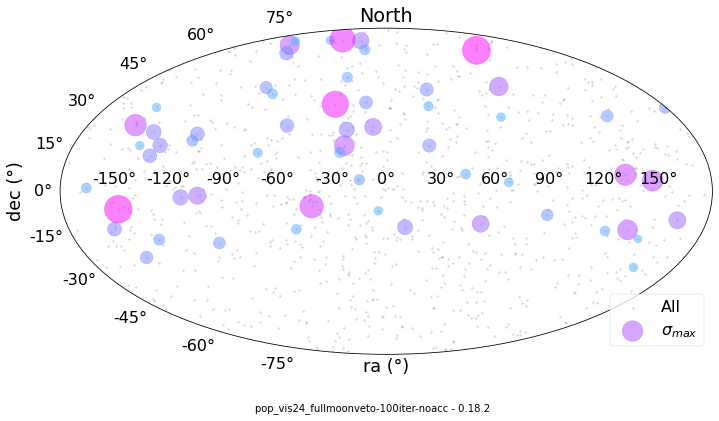

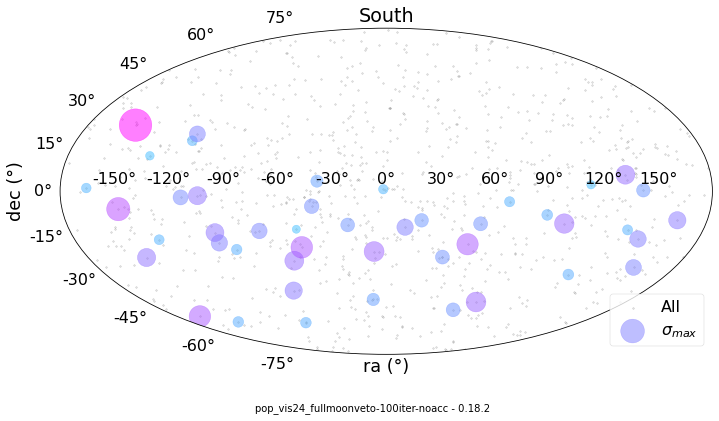

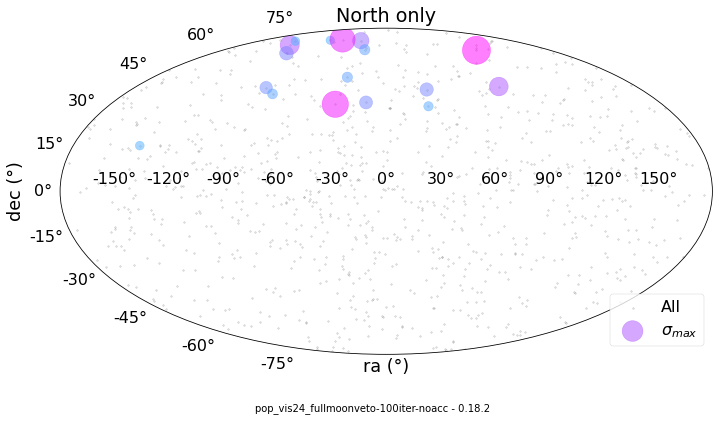

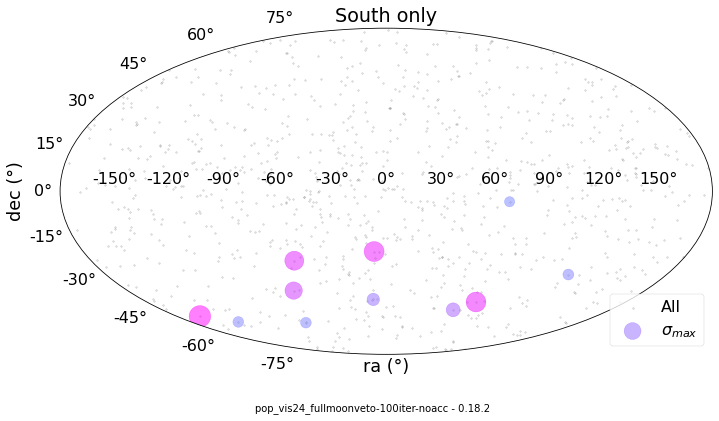

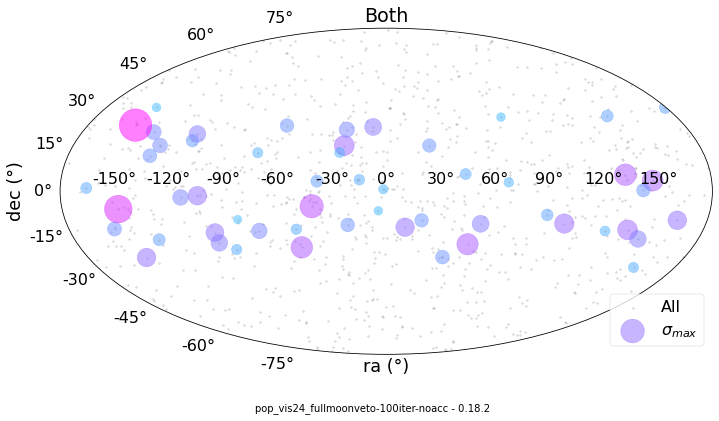

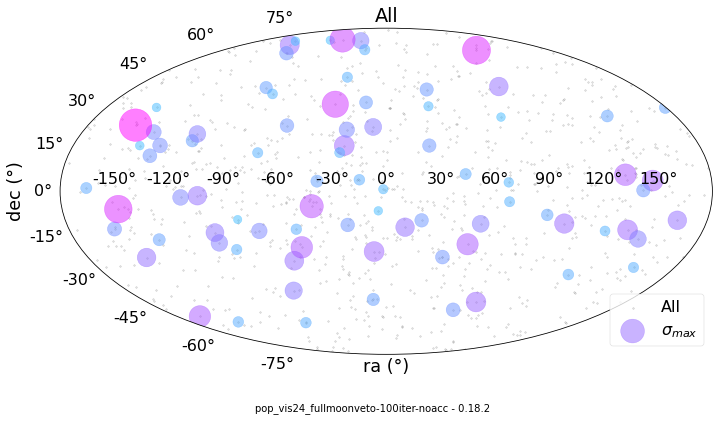

In [12]:
taglist = ["North", "South", "North only","South only","Both", "All"]
poplist = [gn[gn.d5s>eff_lvl],gs[gs.d5s>eff_lvl],
           gn0[gn0.d5s>eff_lvl],gs0[gs0.d5s>eff_lvl],
           gb[gb.d5s>eff_lvl],fullpop[fullpop.d5s>eff_lvl]]

for pop, tag in zip(poplist,taglist):
    
    fig = plt.figure(figsize=(15,6)) 
    ax=fig.add_subplot(111,projection='aitoff')     
    
    radec(popref,pop,ax=ax,label="$\sigma_{max}$", title=tag)


In [13]:
###--------------------------------------------------------------------------------------
def detection_azalt(gpop, ax = None, tag = "No title",  end="5s", start=True, track=True):

    import matplotlib.lines as mlines

    if end=="stop":
        alt = gpop.alt2
        az  = gpop.az2
    elif end=="3s":
        alt = gpop.alt3s
        az  = gpop.az3s        
    elif end=="5s":
        alt = gpop.alt5s
        az  = gpop.az5s  
    elif end=="max":
        alt = gpop.altmx
        az  = gpop.azmx 
        
    with quantity_support():
        # Detected altitude/azimuth
        alt2 =  [Angle(x*u.deg).wrap_at(180*u.deg).to("degree").value for x in gpop.alt2]
        az2  =  [Angle(x*u.deg).wrap_at(180*u.deg).to("degree").value for x in gpop.az2]  
        colors, sizes = col_size(gpop.sigmx)
        sc = ax.scatter(az2, alt2, alpha = 0.6, c= colors, s = sizes,label = MyLabel(az2,label=tag))
        
       # Initial altitude/azimuth
        if start:
            alt1 =  [Angle(x*u.deg).wrap_at(180*u.deg).to("degree").value for x in gpop.alt1]
            az1  =  [Angle(x*u.deg).wrap_at(180*u.deg).to("degree").value for x in gpop.az1]          
            sc = ax.scatter(az1, alt1, alpha = 0.2, 
                            marker="o",color="black",  s = sizes/3, 
                            label = MyLabel(az1))
        
        if track:
            for i in range(0,len(az1)):
                l = mlines.Line2D([az1[i],az2[i]],
                                  [alt1[i],alt2[i]],
                                  ls="--",lw=1.0,color=colors[i],alpha=0.2)
                ax.add_line(l)
#                 ax.arrow(az2[i], alt2[i], 3, 3, shape='full', lw=1, length_includes_head=True, head_width=.05)

        ax.set_xlabel("Azimuth (°)")
        ax.set_ylabel("Altitude (°)")
        ax.set_xlim(xmin=-180,xmax=180)
        ax.set_ylim(ymin=0,ymax=90)
        single_legend(ax,loc="lower right")
     
    return            

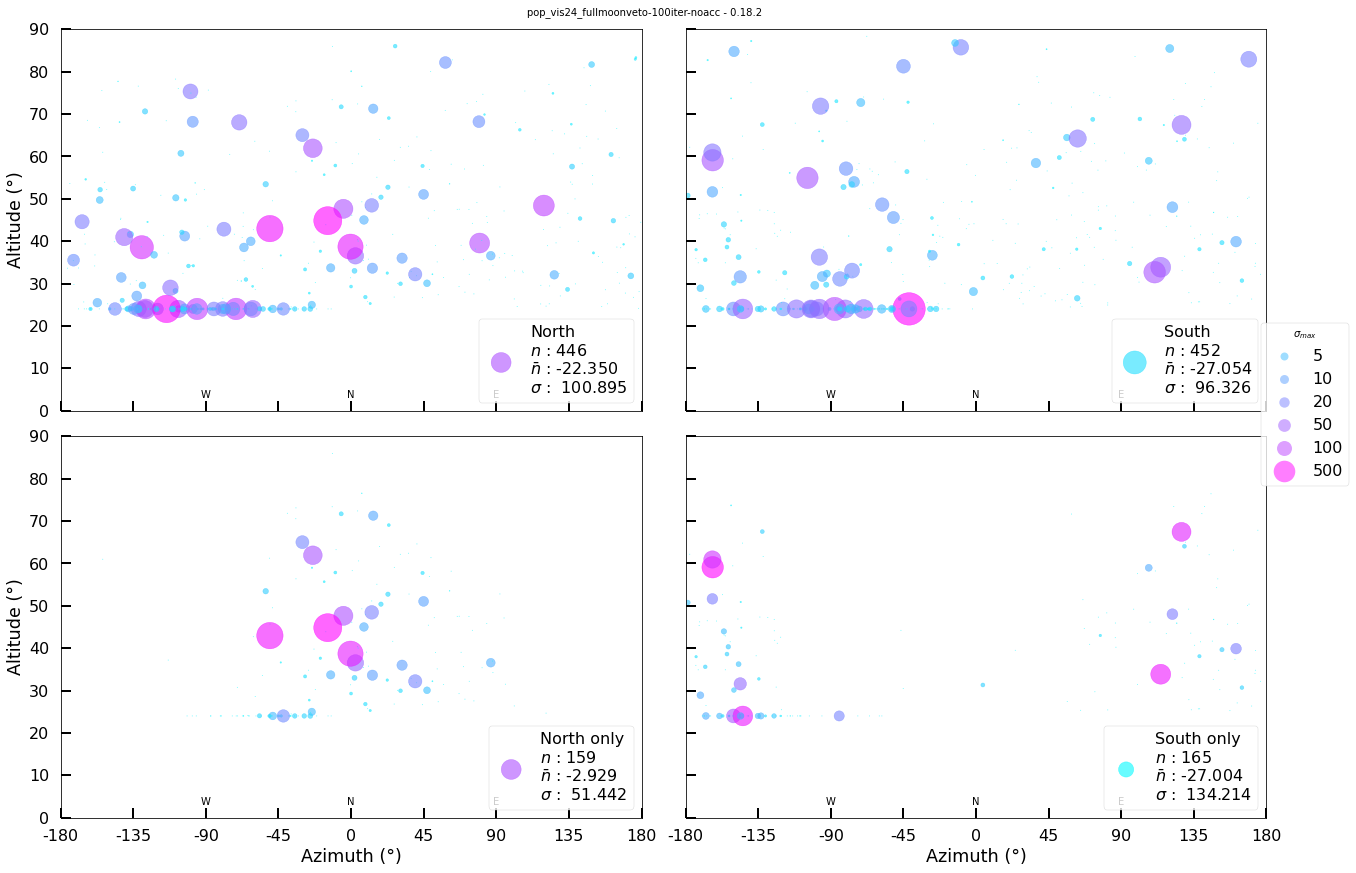

In [14]:
# det_cut = eff_lvl
det_cut = 0

taglist = ["North", "South", "North only","South only"]
poplist = [gn[gn.d5s>=det_cut],  gs[gs.d5s>=det_cut],
           gn0[gn0.d5s>=det_cut],gs0[gs0.d5s>=det_cut]]

nrows =2
ncols = 2
nplots = nrows*ncols
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(18,12),sharex=True,sharey=True) 
# for ax0, pop, tag in zip([ax1, ax2, ax3, ax4], poplist,taglist):

iplot = 0
import itertools
for jrow, icol in itertools.product(range(nrows), range(ncols)):

        ax0 = ax[jrow][icol] if (nrows>1) else ax[icol]
        detection_azalt(poplist[iplot],ax=ax0, tag=taglist[iplot],end="max",track=False,start=False) 

        # Compactify
        if (jrow+1 != nrows): ax0.set_xlabel(None)
        if (icol !=0): ax0.set_ylabel(None)
            
        from matplotlib.ticker import FormatStrFormatter

        positions = np.linspace(-180,180,9)
        ax0.set_xticks([int(p) for p in positions])
        ax0.set_xticklabels( [str(p) for p in positions])
        ax0.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax0.tick_params(which='major', length=10, width=2, direction='in')
        ax0.tick_params(which='minor', length=5, width=2, direction='in')
        
        ax0.text(x=0,y=3,s="N",horizontalalignment="center")
        ax0.text(x=90,y=3,s="E",horizontalalignment="center")
        ax0.text(x=-90,y=3,s="W",horizontalalignment="center")
        iplot+=1
    
patches=sig_legend(ax0)
fig.legend(title="$\sigma_{max}$ ",handles=patches,bbox_to_anchor=[1.05, 0.650],ncol=1)
plt.tight_layout()
stamp(filetag, axis=fig,where="top")


## 3D Universe plot


In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource


from   astropy.visualization import quantity_support
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates.distances import Distance

In [16]:
# Draw 3D sphere in a predefined 3D axis
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def draw_sphere(radius=1, colormap=plt.cm.viridis,ax=None, **kwargs):

    if ax==None:
        fig = plt.figure(figsize=(8,8), dpi=300)
        ax = fig.add_subplot(111, projection='3d')
    
    ax.set_box_aspect(aspect = (1,1,1))

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = radius* np.outer(np.cos(u), np.sin(v))
    y = radius* np.outer(np.sin(u), np.sin(v))
    z = radius* np.outer(np.ones(np.size(u)), np.cos(v))
    
    
    ls = LightSource(azdeg=0, altdeg=65)
    rgb = ls.shade(z, colormap)

    ax.plot_surface(x, y, z,  rstride=1, cstride=1, 
#                     color=color,   
                    facecolors=rgb, linewidth=0, **kwargs)

    return
# draw_sphere(radius=2.3)

28.529430363696868 Gpc


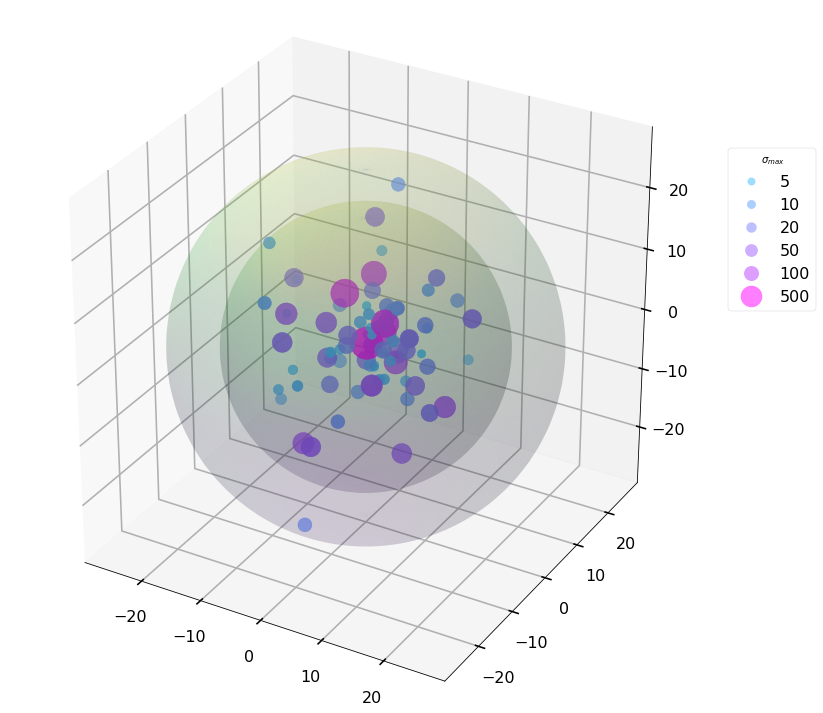

In [19]:
from astropy.cosmology import Planck18 as cosmo


sites = ["all"]
varlist = [fullpop[fullpop.d5s>eff_lvl]]

for gpop, site in zip(varlist,sites):
    
    fig = plt.figure(figsize=(10,10)) 
    
    ax=fig.add_subplot(projection='3d') 
    ax.set_box_aspect(aspect = (1,1,1))
    with quantity_support():

        var = gpop.sigmx
        colors, sizes= col_size(var)
        
        distance = cosmo.luminosity_distance(gpop.z).to('Gpc')
        c1 = coord.SkyCoord(ra=gpop.ra*u.deg, dec=gpop.dec*u.deg,
                            distance=distance)
        
        gc1 = c1.transform_to(coord.Galactocentric)
        x = gc1.x.to('Gpc')
        y = gc1.y.to('Gpc')
        z = gc1.z.to('Gpc')
        dmax = max(max(x),max(y),max(z))
        print(dmax)

        ax.scatter(gc1.x, gc1.y, gc1.z, zdir='z',
                   marker="o",s=sizes,color=colors)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_zlabel(None)
        ax.set_xlim(xmin=-dmax, xmax=dmax)
        ax.set_ylim(ymin=-dmax, ymax=dmax)
        ax.set_zlim(zmin=-dmax, zmax=dmax)

        draw_sphere(radius=dmax.value,ax=ax,alpha=0.1)
        draw_sphere(radius=cosmo.luminosity_distance(2.5).to('Gpc').value,ax=ax,alpha=0.1)
        
        patches=sig_legend(ax)
        fig.legend(title="$\sigma_{max}$",handles=patches,bbox_to_anchor=[1.15, 0.800],ncol=1)
        
plt.tight_layout()

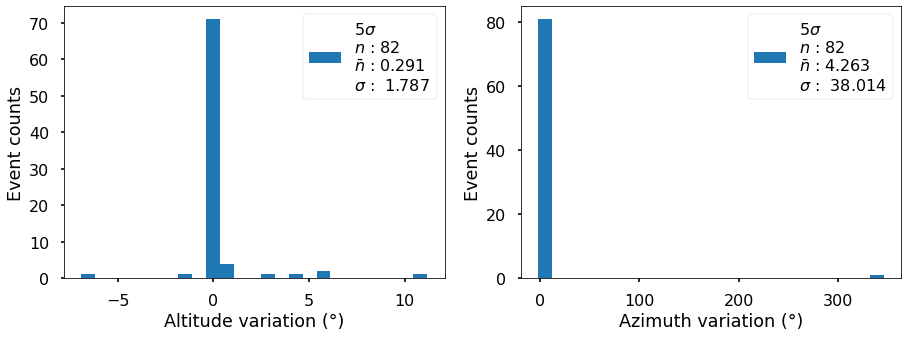

In [20]:
nbin = 25
fig,((ax1,ax2)) = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

for pop, tag  in zip([fullpop[fullpop.d5s>eff_lvl]],["$5\sigma$"]):
    
    ax1.hist(pop.alt5s - pop.alt1,
             bins=nbin,
             label=MyLabel(pop.alt5s-pop.alt1,label=tag))
    ax1.set_xlabel("Altitude variation (°)")
    ax1.set_ylabel("Event counts")
    ax1.legend()
    
    ax2.hist(pop.az5s-pop.az1,
             bins=nbin,
             label=MyLabel(pop.az5s-pop.az1,label=tag))
    ax2.set_xlabel("Azimuth variation (°)")
    ax2.set_ylabel("Event counts")
    ax2.legend()
plt.show()